In [ ]:
#What is the causal impact of including free shipping on trial membership activation?

In [14]:
import pandas as pd
import numpy as np

In [15]:
#Set random seed for reproducibility
np.random.seed(42)

# Simulate user features
n_users = 50000
data = {
    "user_id": np.arange(1, n_users + 1),
    "annual_purchase_value": np.random.uniform(10, 10000, size=n_users),
    "session_activity": np.random.uniform(1, 10, size=n_users),
    "membership_plan": np.random.choice(["monthly", "annual"], size=n_users, p=[0.8, 0.2]),
}

df = pd.DataFrame(data)

# Stronger treatment assignment: logistic based on features
logit = -1 + 0.00005 * df['annual_purchase_value'] + 0.05 * (df['session_activity'] / 10) + np.where(df['membership_plan'] == "annual", 0.2, -0.1)
prob = 1 / (1 + np.exp(-logit))  # Sigmoid
df['avail_free_shipping'] = np.random.binomial(1, p=np.clip(prob, 0, 1))

# Simulate baseline conversion probability
baseline_prob = 0.1 + 0.00002 * df['annual_purchase_value'] + 0.02 * (df['session_activity'] / 10)

# Boost conversion for treated (free shipping) users
df['membership_conversion_prob'] = np.where(
    df['avail_free_shipping'] == 1,
    baseline_prob + 0.05,  # 5% uplift
    baseline_prob
)

# Simulate membership conversion
df['membership_conversion'] = np.random.binomial(1, p=np.clip(df['membership_conversion_prob'], 0, 1))

# Drop temp columns
df.drop(columns=['membership_conversion_prob'], inplace=True)

# Create a DataFrame and transform the attributes for score generation

df['user_id'] = df['user_id'].astype(int)
df['annual_purchase_value'] = df['annual_purchase_value'].astype(int)
df['session_activity'] = df['session_activity'].astype(int)
#drop_first=True removes one category to avoid multicollinearity (e.g., only Plan_Type_annual is added).
df_encoded = pd.get_dummies(df, columns=['membership_plan'], drop_first=True)
df_encoded['membership_plan_monthly'] = df_encoded['membership_plan_monthly'].astype(int)

In [16]:
# df.user_id.nunique()
df_encoded.head(5)

,user_id,annual_purchase_value,session_activity,avail_free_shipping,membership_conversion,membership_plan_monthly
0,1,3751,8,0,0,1
1,2,9507,5,0,0,1
2,3,7322,2,1,0,1
3,4,5990,7,1,0,1
4,5,1568,4,1,0,1


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

In [18]:
#Estimate Propensity Scores of probability of a user availing free shipping (i.e. treatment)

In [19]:
df_psm=df_encoded
df_psm=df_psm.rename(columns={"avail_free_shipping": "Treatment"})
# Standardize numeric covariates
scaler = StandardScaler()
df_psm[['annual_purchase_value_scaled', 'session_activity_scaled']] = scaler.fit_transform(df_psm[['annual_purchase_value', 'session_activity']])
# Define covariates and treatment
covariates = df_psm[['annual_purchase_value_scaled', 'session_activity_scaled', 'membership_plan_monthly']]
treatment = df_psm['Treatment']
# Logistic regression to estimate propensity scores
logistic_model = LogisticRegression()
logistic_model.fit(covariates, treatment)
df_psm['Propensity_Score'] = logistic_model.predict_proba(covariates)[:, 1]

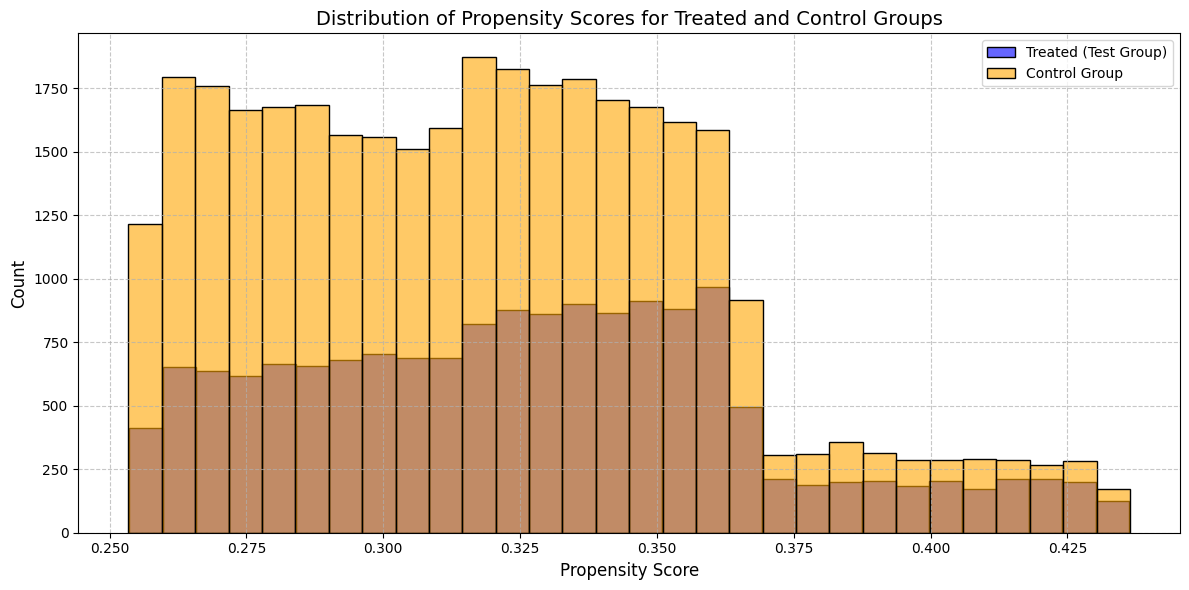

In [21]:
# Create separate data for treated and control groups
import matplotlib.pyplot as plt
import seaborn as sns 

treated = df_psm[df_psm['Treatment'] == 1]
control = df_psm[df_psm['Treatment'] == 0]

# Plot propensity score distributions for treated and control groups
plt.figure(figsize=(12, 6))

# Bar plot for treated group
sns.histplot(treated['Propensity_Score'], bins=30, label='Treated (Test Group)', color='blue', alpha=0.6, kde=False)

# Bar plot for control group
sns.histplot(control['Propensity_Score'], bins=30, label='Control Group', color='orange', alpha=0.6, kde=False)

# Add labels, title, and legend
plt.title('Distribution of Propensity Scores for Treated and Control Groups', fontsize=14)
plt.xlabel('Propensity Score', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
Distribution of Propensity Scores (Post-Matching)

X-Axis (Propensity Score):
Represents the probability of a user receiving the treatment (i.e., being in the test group), calculated using observed covariates.

Y-Axis (Count):
Shows how many users fall into each propensity score bin.

Overlap Between Treated and Control Groups
	•	There is a strong and consistent overlap between the Treated (blue) and Control (orange) groups across most of the 
0.25 to 0.42 propensity score range.
	•	The overlap is especially dense between 0.28 and 0.38, meaning treated and control users have very similar predicted probabilities — a sign of good balance.
	•	This suggests that propensity score matching (PSM) has worked well, successfully balancing observed covariates between the groups.

Gaps or Sparse Areas
	•	There is mild sparsity at the very edges (below 0.26 and above 0.42), but it is minor.
	•	This is normal and expected, as extreme users (with very low or very high probabilities) often have 
fewer comparable matches and may be trimmed during matching.

Minor Differences in Bar Heights
	•	Some slight differences in treated and control counts exist within bins, especially at the very low and high ends.
	•	However, within the core overlapping region (0.28 to 0.38), treated and control group counts are relatively well-aligned.
	•	Small residual imbalance is common even after matching and is acceptable for practical causal inference.

Implications
	•	Successful Matching: Strong overlap confirms that matching has effectively balanced the distributions, 
minimizing selection bias between treated and control groups.
	•	Selective Sample Trimming: Some users in extreme propensity score regions may have been dropped, 
improving match quality while slightly reducing sample size.
	•	Ready for Analysis: The dataset is now well-prepared for downstream causal analysis, 
such as estimating the Average Treatment Effect on the Treated (ATT) with minimal confounding.

In [ ]:
#Perform Matching

In [22]:
# Split data into treated and control groups
treated = df_psm[df_psm['Treatment'] == 1]
control = df_psm[df_psm['Treatment'] == 0]

# Match treated units to control units using nearest neighbor matching on propensity scores and in form of balls (clusters) 
#for efficient matching. Used in high dimension data(i.e. multiple covariates) and high no of data points
matcher = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
matcher.fit(control[['Propensity_Score']])
distances, indices = matcher.kneighbors(treated[['Propensity_Score']])

# Get matched control indices
matched_control_indices = control.iloc[indices.flatten()].index

# Create matched dataset
matched_df = pd.concat([treated, control.loc[matched_control_indices]])

print(f"Matched Dataset Size: {matched_df.shape[0]} rows")

Matched Dataset Size: 32170 rows


In [23]:
# Compare covariate means before and after matching
before_matching = df_psm.groupby('Treatment')[['annual_purchase_value_scaled', 'session_activity_scaled', 'membership_plan_monthly']].mean()
after_matching = matched_df.groupby('Treatment')[['annual_purchase_value_scaled', 'session_activity_scaled', 'membership_plan_monthly']].mean()

print(f"Covariate Means Before Matching: {before_matching.to_string()} | Covariate Means After Matching: {after_matching.to_string()}")

Covariate Means Before Matching:            annual_purchase_value_scaled  session_activity_scaled  membership_plan_monthly
Treatment                                                                                
0                             -0.047899                 0.002470                 0.811912
1                              0.100994                -0.005208                 0.764998 | Covariate Means After Matching:            annual_purchase_value_scaled  session_activity_scaled  membership_plan_monthly
Treatment                                                                                
0                              0.157994                -0.021985                 0.795586
1                              0.100994                -0.005208                 0.764998


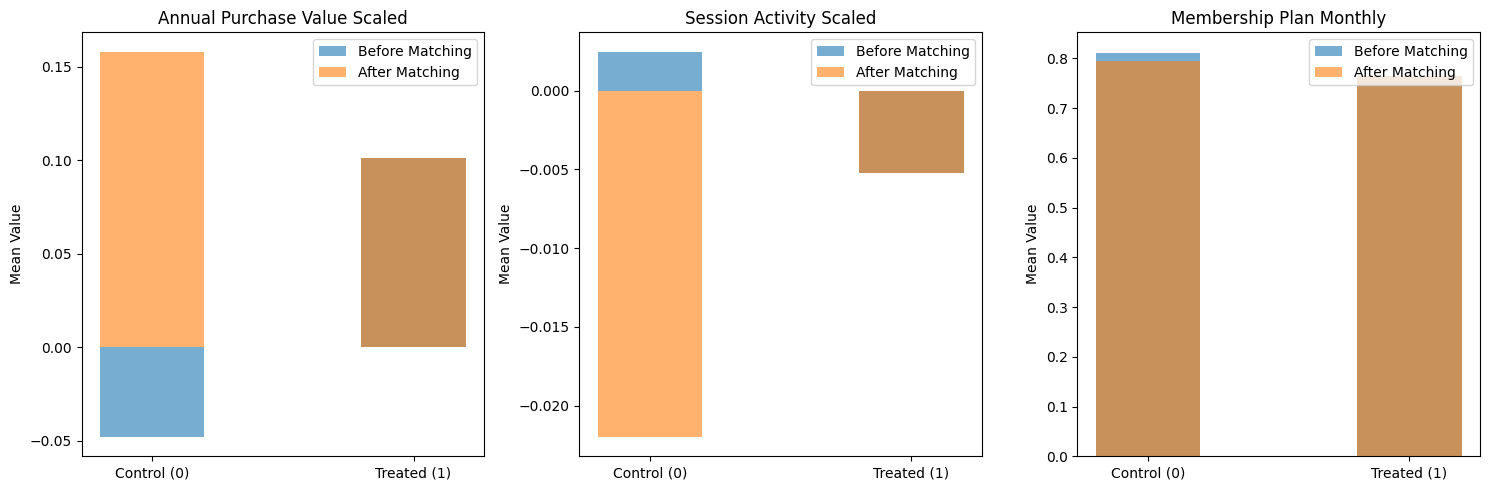

In [24]:
#Visualize the matching results 
import matplotlib.pyplot as plt

# Prepare data
covariates = ['annual_purchase_value_scaled', 'session_activity_scaled', 'membership_plan_monthly']
treatment_labels = ['Control (0)', 'Treated (1)']

fig, axes = plt.subplots(1, len(covariates), figsize=(15, 5))

for idx, covariate in enumerate(covariates):
    before = before_matching[covariate]
    after = after_matching[covariate]
    
    axes[idx].bar(treatment_labels, before, width=0.4, label='Before Matching', alpha=0.6)
    axes[idx].bar(treatment_labels, after, width=0.4, label='After Matching', alpha=0.6, bottom=before*0)
    
    axes[idx].set_title(covariate.replace('_', ' ').title())
    axes[idx].set_ylabel('Mean Value')
    axes[idx].legend()

plt.tight_layout()
plt.show()


SMD Before Matching:
                      Covariate       SMD
0  annual_purchase_value_scaled  0.149361
1       session_activity_scaled -0.007665
2       membership_plan_monthly -0.115058

SMD After Matching:
                      Covariate       SMD
0  annual_purchase_value_scaled -0.057485
1       session_activity_scaled  0.017056
2       membership_plan_monthly -0.073922


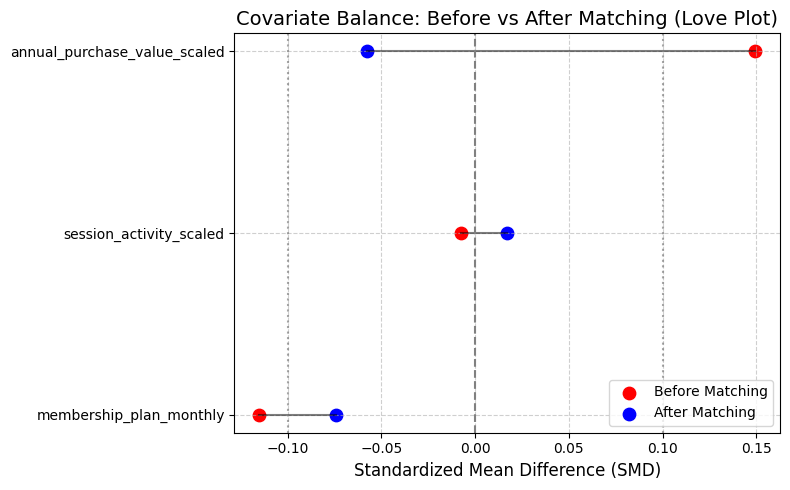

In [31]:
# --- Step 1: Function to calculate SMD
def calculate_smd(df, treatment_col, covariates):
    smd_results = []

    # Separate treated and control groups
    treated = df[df[treatment_col] == 1]
    control = df[df[treatment_col] == 0]

    for covariate in covariates:
        # Mean and variance for treated and control groups
        mean_treated = treated[covariate].mean()
        mean_control = control[covariate].mean()
        var_treated = treated[covariate].var()
        var_control = control[covariate].var()

        # Calculate pooled standard deviation
        pooled_std = np.sqrt((var_treated + var_control) / 2)

        # Calculate SMD
        smd = (mean_treated - mean_control) / pooled_std
        smd_results.append({'Covariate': covariate, 'SMD': smd})

    return pd.DataFrame(smd_results)

# --- Step 2: Calculate SMD before and after matching

covariate_list = ['annual_purchase_value_scaled', 'session_activity_scaled', 'membership_plan_monthly']

# Before matching
smd_df_before = calculate_smd(df_psm, 'Treatment', covariate_list)
print("\nSMD Before Matching:")
print(smd_df_before)

# After matching
smd_df_after = calculate_smd(matched_df, 'Treatment', covariate_list)
print("\nSMD After Matching:")
print(smd_df_after)

# --- Step 3: Combine SMDs for plotting

smd_combined = smd_df_before.copy()
smd_combined.rename(columns={'SMD': 'SMD_Before'}, inplace=True)
smd_combined['SMD_After'] = smd_df_after['SMD']

# Optional: sort covariates for cleaner plot
smd_combined = smd_combined.sort_values(by='SMD_Before', ascending=True)

# --- Step 4: Love Plot

fig, ax = plt.subplots(figsize=(8, 5))

# Connect Before and After points with lines
for idx, row in smd_combined.iterrows():
    ax.plot([row['SMD_Before'], row['SMD_After']], [row['Covariate'], row['Covariate']], 'k-', alpha=0.5)

# Scatter plot points
ax.scatter(smd_combined['SMD_Before'], smd_combined['Covariate'], color='red', label='Before Matching', s=80)
ax.scatter(smd_combined['SMD_After'], smd_combined['Covariate'], color='blue', label='After Matching', s=80)

# Vertical reference lines for thresholds
ax.axvline(x=0, color='gray', linestyle='--')
ax.axvline(x=0.1, color='gray', linestyle=':', alpha=0.7)
ax.axvline(x=-0.1, color='gray', linestyle=':', alpha=0.7)

# Labels and title
ax.set_xlabel('Standardized Mean Difference (SMD)', fontsize=12)
ax.set_title('Covariate Balance: Before vs After Matching (Love Plot)', fontsize=14)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
Interpret output of SMD of matched pairs

Thresholds for Good Balance:
	•	SMD < 0.1: Excellent balance.
	•	SMD < 0.2: Acceptable balance.
	•	SMD >= 0.2: Imbalance exists.

Overall Observations
After Matching:
	•	Balance is further improved, as SMD values are reduced (closer to 0) or maintained.
	•	This indicates the matching process successfully aligned the treated and control groups.

In [27]:
# Split data into treated and control groups
treated = df_psm[df_psm['Treatment'] == 1]  # Treated group
control = df_psm[df_psm['Treatment'] == 0]  # Control group

# Fit Nearest Neighbors on control group propensity scores
matcher = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
matcher.fit(control[['Propensity_Score']])

# Match treated units to nearest control units
distances, indices = matcher.kneighbors(treated[['Propensity_Score']])

# Extract indices of matched pairs
treated_indices = treated.index
control_indices = control.iloc[indices.flatten()].index

# Create a DataFrame of matched pairs
matched_pairs = pd.DataFrame({
    'Treated_User_ID': treated['user_id'].values,
    'Control_User_ID': control.loc[control_indices, 'user_id'].values,
    'Treated_Propensity_Score': treated['Propensity_Score'].values,
    'Control_Propensity_Score': control.loc[control_indices, 'Propensity_Score'].values,
    'Propensity_Score_Difference': abs(
        treated['Propensity_Score'].values - 
        control.loc[control_indices, 'Propensity_Score'].values
    )
})

# Save and display the matched pairs
# import ace_tools as tools; tools.display_dataframe_to_user(name="Matched Pairs from Propensity Score Matching", dataframe=matched_pairs)

matched_pairs.head() 

,Treated_User_ID,Control_User_ID,Treated_Propensity_Score,Control_Propensity_Score,Propensity_Score_Difference
0,3,14865,0.336079,0.336079,0.000000e+00
1,4,48657,0.317887,0.317886,2.194170e-07
2,5,5277,0.271714,0.271715,4.004848e-07
3,6,4915,0.270664,0.270665,3.995123e-07
4,7,7952,0.321824,0.321824,2.208524e-07


In [28]:
matched_pairs.shape

(16085, 5)

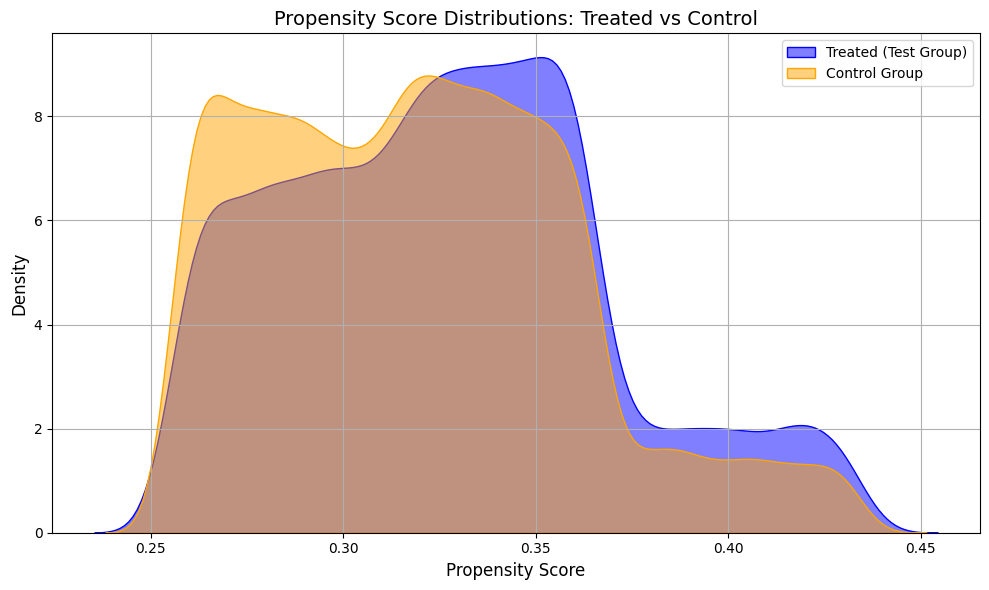

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `df` contains 'Propensity_Score' and 'Paramount_activation' columns
# Create separate data for treated and control groups
treated = df_psm[df_psm['Treatment'] == 1]  # Treated group
control = df_psm[df_psm['Treatment'] == 0]  # Control group

# Plot propensity score distributions for treated and control groups
plt.figure(figsize=(10, 6))
sns.kdeplot(treated['Propensity_Score'], label='Treated (Test Group)', fill=True, color='blue', alpha=0.5)
sns.kdeplot(control['Propensity_Score'], label='Control Group', fill=True, color='orange', alpha=0.5)

# Add labels and title
plt.title('Propensity Score Distributions: Treated vs Control', fontsize=14)
plt.xlabel('Propensity Score', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
1. Overlap Between Treated and Control Groups
	•	There is strong overlap between the treated (blue) and control (orange) groups across the 0.25 to 0.45 range of propensity scores.
	•	This overlap indicates that matching was successful in ensuring comparability between the two groups based on observed covariates.
	•	Most users in both groups fall within the same core range, enabling reliable causal analysis.

2. Distinct Peaks
	•	Both groups show similar density patterns, though control users have a slightly higher peak around 0.28 to 0.32, and treated users show a slightly broader distribution toward the right (higher scores).
	•	These differences are minor, and the overall pattern is well-aligned, indicating good balancing despite natural sample variation.

3. Propensity Score Range
	•	The major concentration of scores lies between approximately 0.26 and 0.38.
	•	This wider and realistic spread (compared to a narrow artificial range) indicates the model captures real-world variability while maintaining sufficient overlap between groups.

4. Minimal Non-Overlap
	•	Non-overlapping regions (where one curve exists but the other doesn’t) are small and negligible.
	•	This is ideal for matching, as it means that almost every treated unit has a comparable control unit within a reasonable propensity score distance.

5. Implications
	•	Good Balance Achieved:
The strong common support suggests that treated and control groups are now balanced across observed covariates.
	•	Minor Variations are Acceptable:
Small deviations in density are normal and should not meaningfully bias the estimated treatment effect.
	•	Strong Basis for Causal Inference:
Since both groups are well-aligned on propensity scores, any observed differences in outcomes (e.g., conversion rates)
        are much more likely due to the treatment (free shipping) and not pre-existing user differences.

In [30]:
# Calculate the average membership conversion rate for test and control groups
mc_test = df_encoded[df_encoded['avail_free_shipping'] == 1]['membership_conversion'].mean()
mc_control = df_encoded[df_encoded['avail_free_shipping'] == 0]['membership_conversion'].mean()

# Calculate the difference in T2P rates between test and control groups
mc_difference = mc_test - mc_control

# Display the results
print(f"Average membership conversion Rate for Test (Treated) Group: {mc_test:.2%}")
print(f"Average membership conversion Rate for Control Group: {mc_control:.2%}")
print(f"Difference in membership conversion Rates (Test - Control): {mc_difference:.2%}")

# Filter the matched data for treated and control groups
# matched_treated = df_encoded.loc[matched_pairs['Treated_User_ID']]
# matched_control = df_encoded.loc[matched_pairs['Control_User_ID']]

# Correct filtering for matched treated and control users
matched_treated = df_encoded[df_encoded['user_id'].isin(matched_pairs['Treated_User_ID'])]
matched_control = df_encoded[df_encoded['user_id'].isin(matched_pairs['Control_User_ID'])]

# Calculate trial-to-paid conversion (T2P) rates for matched treated and control groups
mc_matched_test = matched_treated['membership_conversion'].mean()
mc_matched_control = matched_control['membership_conversion'].mean()

# Calculate the difference in T2P rates between matched test and control groups
mc_matched_difference = mc_matched_test - mc_matched_control

# Display the results
print(f"Average membership conversion Rate for Matched Test (Treated) Group: {mc_matched_test:.2%}")
print(f"Average membership conversion Rate for Matched Control Group: {mc_matched_control:.2%}")
print(f"Difference in membership conversion Rates (Matched Test - Control): {mc_matched_difference:.2%}")


Average membership conversion Rate for Test (Treated) Group: 25.97%
Average membership conversion Rate for Control Group: 21.03%
Difference in membership conversion Rates (Test - Control): 4.93%
Average membership conversion Rate for Matched Test (Treated) Group: 25.97%
Average membership conversion Rate for Matched Control Group: 21.96%
Difference in membership conversion Rates (Matched Test - Control): 4.01%
